### Read in Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import researchpy as rp

from descartes.patch import PolygonPatch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.collections import PatchCollection

In [3]:
listings_detail = pd.read_excel('../CourseProject/data/listings_detail.xlsx', index_col=0)
calendar_detail = pd.read_excel('../CourseProject/data/calendar_detail.xlsx' , index_col=0)
neighbourhoods = pd.read_excel('../CourseProject/data/neighbourhoods.xlsx', index_col=0)
reviews = pd.read_excel('../CourseProject/data/reviews_detail.xlsx', index_col=0)
crime = pd.read_excel('../CourseProject/data/NYPD_Arrests_Data__Historic_.xlsx', index_col=0)
nbgeo = gpd.read_file('../CourseProject/data/neighbourhoods.geojson')
ls=pd.read_csv('../CourseProject/data/listings_summary.csv', index_col=0)

### Data Cleaning
There are many missing values which either need to be removed or estimated so that they do not affect our results

In [2]:
#How many records we start with
print(f'Number of records: {listings_detail.count()[0]}')

Number of records: 44317


In [87]:
#What is missing in listing summary?
ls.isna().sum()

name                                28
host_id                              0
host_name                          232
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       9440
reviews_per_month                 9474
calculated_host_listings_count       0
availability_365                     0
dtype: int64

No values that are essential to our analysis are missing in listing summary

In [100]:
#What is missing in listing details?
listings_detail.isna().sum()

listing_url                         0    
scrape_id                           0    
last_scraped                        0    
name                                39   
summary                             1523 
space                               14514
description                         29   
experiences_offered                 0    
neighborhood_overview               18720
notes                               28229
transit                             16986
access                              19127
interaction                         19965
house_rules                         19208
thumbnail_url                       3305 
medium_url                          3305 
picture_url                         0    
xl_picture_url                      3305 
host_id                             0    
host_url                            0    
host_name                           232  
host_since                          232  
host_location                       406  
host_about                        

There are many missing values in the listing details dataset which we need to either estimate or eliminate. We estimate the missing reviews per month by using the median values. Then we also want to remove records that do not have a room and that are "free". 

In [23]:
#Fix NaN in review per month 

#Estimate attempt:
#Use to fill in missing values with median
def impute_median(series):
    return series.fillna(series.median())

listings_detail.loc['reviews_per_month']=listings_detail["reviews_per_month"].transform(impute_median)


#Remove records that do not have a room to offer
listings_detail=listings_detail[listings_detail['room_type'] != 0]

#Remove records that are "free"
listings_detail=listings_detail[listings_detail['price']!=0]

In [24]:
#How many records we have now
print(f'Number of records after cleaning: {listings_detail.count()[0]}')

Number of records after cleaning: 44267


Some prices are extremely high, there are 44 with prices over 2000 per night. Some of these really are the prices but it seems like some are priced at $10,000 even though that is not the actual price and they are not available at all. We may need to go through each URL and see which ones are really that expensive and which should be taken out. 

In [153]:
listings_detail[listings_detail.price>2000][:5]

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99
id,,,,,,,,,,,,,,,,,,,,,
7003697,https://www.airbnb.com/rooms/7003697,20171000000000,2017-10-02,Furnished room in Astoria apartment,1 room with a twin bed in a 2 bedroom apartmen...,1 furnished bedroom in a 2 bedroom Astoria apa...,1 room with a twin bed in a 2 bedroom apartmen...,none,"Quiet, extremely safe, no parking space but I ...",NaN,...,f,strict,f,f,1,0.08,NaN,NaN,NaN,NaN
14800877,https://www.airbnb.com/rooms/14800877,20171000000000,2017-10-03,Heart of Brooklyn your perfect Spacious LOFT,Introducing a new event space located in the t...,NaN,Introducing a new event space located in the t...,none,NaN,NaN,...,f,strict,f,f,1,NaN,NaN,NaN,NaN,NaN
18071399,https://www.airbnb.com/rooms/18071399,20171000000000,2017-10-03,West Chelsea Studios - Penthouse,Natural light in the heart of Chelsea. Our day...,"This is a non-smoking photo-video studio, show...",Natural light in the heart of Chelsea. Our day...,none,Chelsea is the gallery district on the west si...,Freight elevator availability: Mon-Fri 7:30a-...,...,f,strict,f,f,2,NaN,NaN,NaN,NaN,NaN
2271504,https://www.airbnb.com/rooms/2271504,20171000000000,2017-10-03,SUPER BOWL Brooklyn Duplex Apt!!,Fantastic Duplex Apt in a Townhouse in one of ...,NaN,Fantastic Duplex Apt in a Townhouse in one of ...,none,NaN,NaN,...,f,flexible,f,f,1,NaN,NaN,NaN,NaN,NaN
2952861,https://www.airbnb.com/rooms/2952861,20171000000000,2017-10-02,Photography Location,"RATES Parlor floor only living room, den, din...","Built in 1887, this magnificent landmarked 10,...","RATES Parlor floor only living room, den, din...",none,Clinton Hill,NaN,...,f,strict,t,t,11,0.08,NaN,NaN,NaN,NaN


### EDA 

In [41]:
#there's 202 unique neighborhoods - do we want to reduce this? how?
listings_detail['neighbourhood'].nunique()

203

In [35]:
print(cdmergels.date.min())
print(cdmergels.date.max())

2017-10-02 00:00:00
2018-10-02 00:00:00


Our data is from October 2, 2017 to October 2, 2018

### <b> Question 1: </b>
Is there a difference in the cost, popularity, and ratings for different areas? Do additional research to learn why.

#### Price

In [38]:
rp.summary_cont(ls['price'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,price,44317.0,147.675948,209.138888,0.993458,145.728753,149.623144


That gives us data by whole, but we really are interested in the data by neighbourhood

In [39]:
rp.summary_cont(ls['price'].groupby(ls['neighbourhood_group']))

,N,Mean,SD,SE,95% Conf.,Interval
neighbourhood_group,,,,,,
Bronx,791,88.910240,147.269875,5.236314,78.640571,99.179909
Brooklyn,18470,120.701624,178.882444,1.316238,118.121729,123.281520
Manhattan,20370,185.082867,233.717036,1.637551,181.873188,188.292546
Queens,4392,99.620674,174.882615,2.638855,94.447930,104.793418
Staten Island,294,126.517007,311.045103,18.140519,90.900967,162.133047


Slightly different summary below

In [132]:
ls.price.groupby(ls['neighbourhood_group']).describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,791.0,88.910240,147.269875,0.0,47.0,65.0,90.0,2500.0
Brooklyn,18470.0,120.701624,178.882444,0.0,60.0,90.0,147.0,10000.0
Manhattan,20370.0,185.082867,233.717036,0.0,90.0,140.0,200.0,9999.0
Queens,4392.0,99.620674,174.882615,0.0,55.0,75.0,110.0,10000.0
Staten Island,294.0,126.517007,311.045103,0.0,52.0,80.0,120.0,5000.0


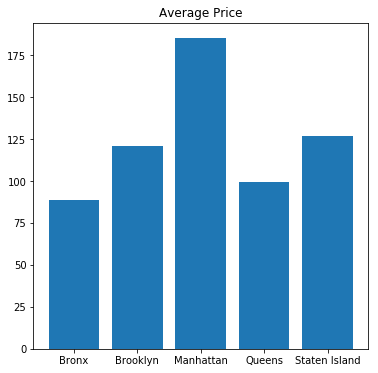

In [92]:
# Price
price_group = ls[["neighbourhood_group","price"]].groupby(["neighbourhood_group"]).price.mean()
plt.figure(figsize = (6,6))
plt.bar(range(len(price_group.values)),price_group.values)
plt.xticks(range(len(price_group.values)),list(price_group.index))
plt.title("Average Price");

It seems like Airbnb's in Manhattan are the most expensive overall in comparison to the other neighborhood groups. Staten Island and Brooklyn are the next most expensive with Staten Island seeming to be just slightly more expensive. Then Queens and finally the Bronx is the least expensive on average, however, it is pretty close to the other three group overall. 

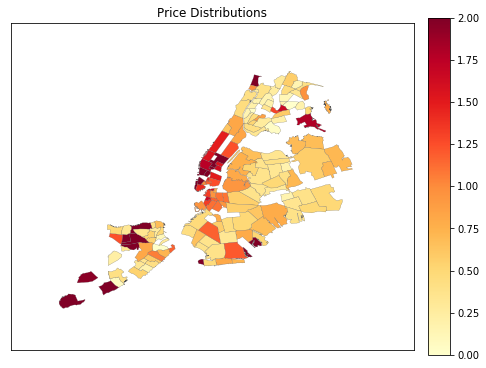

In [91]:
# Price Geometry Distribution 

prices = listings_detail[["neighbourhood","price","reviews_per_month"]].groupby(["neighbourhood"]).price.mean()
priceMap = dict(prices)

max_ = max(priceMap.values())
min_ = min(priceMap.values())
def norm_transform(price):
    return (price-min_)/( 250 - min_)#Hard Coding Truncature Here at 250 USD here to see a more meaningful result

###############SET UP LIMITS#########################
mp = nbgeo.geometry.loc[101]
cm = plt.get_cmap('YlOrRd')
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = mp.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 20 * w, maxx + 5 * w)
ax.set_ylim(miny - 10 * h, maxy + 8 * h)
ax.set_aspect(1)

###############ADD NEIGHBOURS#########################
for i in range(len(nbgeo.geometry)):
    patches = []
    mp = nbgeo.geometry.loc[i]
    nb = nbgeo.neighbourhood.loc[i]
    try:
        price = priceMap[nb]
    except:
        continue
    for idx, p in enumerate(mp):
        colour = cm(norm_transform(price))
        patches.append(PolygonPatch(p, fc=colour, ec='#555555', lw=0.2, alpha=1., zorder=1))
        ax.add_collection(PatchCollection(patches, match_original=True))

###############DRAW##################################
ax.set_xticks([])
ax.set_yticks([])
plt.title("Price Distributions")
plt.tight_layout()
##NOTE that the price values are normalized 
ax  = fig.add_axes([1,0.11,0.05,0.78])
norm = mpl.colors.Normalize(vmin=0,vmax=2)
cb1  = mpl.colorbar.ColorbarBase(ax,cmap=cm,norm=norm,orientation='vertical')

plt.show()

#### Popularity
We are defining popularity in terms of availibilty, meaning more popular airbnb's have less availability and less popular ones have more

In [4]:
#Change t and f to 1 and 0 
calendar_detail.available=calendar_detail.available.map(dict(t=1, f=0))

In [5]:
#Merge calendar details with listing details by listing_id to get the neighborhood group of each listing
cdmergels=pd.merge(calendar_detail, ls, left_on='listing_id', right_index=True, how='left')

In [71]:
cdmergels['available'].groupby(cdmergels['neighbourhood_group']).sum()
#Number of availibilities by neighborhood - higher means less popular

neighbourhood_group
Bronx             10981
Brooklyn         252356
Manhattan        261394
Queens            43330
Staten Island      7211
Name: available, dtype: int64

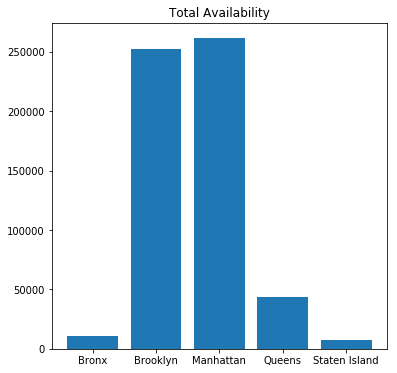

In [94]:
# Total Availability
avail_group = cdmergels[["neighbourhood_group","available"]].groupby(["neighbourhood_group"]).available.sum()
plt.figure(figsize = (6,6))
plt.bar(range(len(avail_group.values)),avail_group.values)
plt.xticks(range(len(avail_group.values)),list(avail_group.index))
plt.title("Total Availability");

This can be misleading since there are way more Airbnbs in general in Manhattan and Brooklyn, so there will therefore be more available rooms. Maybe we can make this relative to the amount of Airbnb's there are so that we get an average available days per Airbnb by neighborhood.

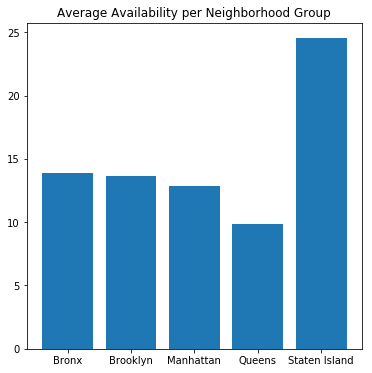

In [95]:
# Average Availability
avail_group = (cdmergels[["neighbourhood_group","available"]].groupby(["neighbourhood_group"]).available.sum())/(ls['host_id'].groupby(ls['neighbourhood_group']).count())
plt.figure(figsize = (6,6))
plt.bar(range(len(avail_group.values)),avail_group.values)
plt.xticks(range(len(avail_group.values)),list(avail_group.index))
plt.title("Average Availability per Neighborhood Group");

This plot paints a much different picture which is much more accurate. For the amount of Airbnb's there are in Staten Island, they are on average more available than any other neighbourhood group. This is the availability relative to the amount of Airbnb's in the area. The Bronx, Brooklyn, and Manhattan have VERY similar averages which is interesting. Queens seems to be the more popular since it has the least availability.

I used the values below to check that the average was calculated properly which it was. It is the amount of available days per neighbourhood group divided by the total number of Airbnbs in each neighborhood group - to get the average amount of available days per Airbnb within each neighborhood group (borough)

In [78]:
avail_group #Used this to check that this is the amount of available days for each neighborhood group 
            #divided by the amount of Airbnbs per ng - it's correct.

neighbourhood_group
Bronx            13.882427
Brooklyn         13.663021
Manhattan        12.832302
Queens            9.865665
Staten Island    24.527211
dtype: float64

##### Are there times when no Airbnbs are available or extremely limited and on what dates does this occur?

In [31]:
cdmergels.available.groupby(cdmergels.date).sum().sort_values()[:10]

date
2017-10-02    190
2017-10-07    309
2017-10-06    331
2017-10-03    397
2017-10-05    401
2017-10-04    435
2017-10-08    467
2017-10-13    559
2017-10-14    569
2017-10-09    593
Name: available, dtype: int64

There are no times when there are no Airbnbs available but the dates when the fewest are available are October 10, October 7, October 6, October 3, and October 5, 2017 

In [32]:
cdmergels.available.groupby(cdmergels.date).sum().sort_values(ascending=False)[:10]

date
2018-03-20    1849
2018-03-22    1846
2018-03-21    1845
2018-03-19    1843
2018-03-23    1843
2018-03-17    1839
2018-03-18    1838
2018-03-25    1834
2018-03-24    1832
2018-03-15    1831
Name: available, dtype: int64

The dates with the greatest number of Airbnb's available are around March 20th, 2018

#### Reviews

In [4]:
pd.set_option('display.max_colwidth', -1)

In [133]:
len(reviews.index)

801784

There are 801,784 reviews total. First we will try to extract as many positive comments as possible. However, we may not account for all of them since there are so many different positive words that can be included in the comments. Also, some comments have some positive feedback and some negative feeback as well. In these cases, the feedback is overall positive but a few issues or problems are pointed out. Since many that I looked over seem to be mostly postive than negative, we search for negative comments from ones that are not found as positive. This way we get comments that are overall positive and overall negative. 

In [134]:
reviews['goodcomments'] = reviews['comments'].str.contains('good|great|wonderful|love|nice|loved|prompt|awesome|easy|lovely|accommodating|neat|perfect|would_recommend|terrific|fantastic|responsive|kind|pleasure|pleasant|ideal|convenient|beautiful|clean|enjoy|easily_accesible|friendly|welcoming|quiet|helpful|comf|best|reasonable|priva|communicative|appreciate|modern|value|thank|decent|cool|worth|amazing', case=False)

In [135]:
len(reviews[reviews['goodcomments']==True])

696965

683,888 reviews are considered "positive" by our definition, meaning it contains at least one of the words above. This is not a perfect approach and it is not guarenteed that all of these comments are positive but that is what we are assuming. Next, we take the reviews that are not considered positive and find which ones are negative. We cannot just subtract the amount of positive reviews from the total number of reviews since there are many cases where the review is in a different language or a default review of "The host canceled this reservation. This is an automated posting." We don't want those to be considered negative since they may not be. 

In [136]:
reviews['badcomments']=reviews['comments']

In [137]:
reviews.loc[reviews['goodcomments']==True, 'badcomments']=None

In [176]:
reviews['badcomments']=reviews['comments'].str.contains('messy|dirty|expensive|loud|nois|bugs|warning|bad|awful|refund',case=False)

In [178]:
len(reviews[reviews['badcomments']==True])

48919

In [140]:
696965+2952

699917

In [179]:
696965+48919

745884

So we've only accounted for 699927 out of the 801784 reviews total. We may still need to try to find out the number of reviews that are automated or in a different language to see how many we have missed. 

In [145]:
reviewsmergels=pd.merge(reviews, ls, left_index=True, right_index=True, how='left')

In [147]:
reviewsmergels

,id,date,reviewer_id,reviewer_name,comments,badcomments,goodcomments,bcomments,name,host_id,...,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2515,198,2008-10-13,2603,Jenny,Stephanie was a wonderful host! Her apartment was beautiful and extremely clean. We had a very nice (and affordable!) stay in the city with private room and own bathroom.,NaN,True,NaN,Stay at Chez Chic budget room #1,2758,...,40.799205,-73.953676,Private room,59,2,156,2017-07-31,1.43,3,292
2515,859,2009-03-08,8455,Roland,"Such a wonderful place and very close to the metro station on the line 1 2 3. She was awesome with us, it was a pleasure to stay in her appt. she's french, so last word ...\r\nMerci encore stephanie pour ton hospitalitÃ©. On a passÃ© un super sÃ©jour avec toi. TrÃ¨s disponible pour nous avec pleins de conseils, je vous recommande particulierement cette adresse qui plus est pour un prix raisonnable. Le metro est juste a 1 bloc de l'appartement et la ligne 1-2-3 est la plus centrale et la plus pratique de NYC. son quartier est vraiment tres sympa en plus !!! Allez y les yeux fermÃ©s.",NaN,True,NaN,Stay at Chez Chic budget room #1,2758,...,40.799205,-73.953676,Private room,59,2,156,2017-07-31,1.43,3,292
2515,1083,2009-03-25,9759,Cem,"I just got back from a trip to NYC during which I stayed at Stephanie's appartment. The bedroom and private bathroom that comes with it were both kept very clean and are spacious so that I could unpack my stuff and put my clothes away in the closet. I didn't have to live out of my rucksack for ten days which made me already feel comfortable.\r\nThe appartment is situated right at the north end of Central Park in Harlem and very close to different subway stations. I could either start my day with a morning stroll through the park and into the Upper West or Upper East Side, or catch the subway to get to Midtown, South Manhattan or Brooklyn in no time. So from a geographical vantage point the appartment is perfectly situated to discover the city.\r\nBut apart from all these facts it was above all Stephanie with her warm and welcoming nature that really made me feel comfortable during these days. It is very nice to come ""home"" in the evening, tired after a long day's strolling around, and end the day with a little chit-chat about one's experiences before falling into bed and, with thumb-in-mouth, sleep blissfully through till the next morning.\r\nNYC, I will be back, and I know where I'll be staying! Thank you, Stephanie!!!",NaN,True,NaN,Stay at Chez Chic budget room #1,2758,...,40.799205,-73.953676,Private room,59,2,156,2017-07-31,1.43,3,292
2515,1107,2009-03-27,9193,Holly,Stephanie's offered all the most important things: a warm welcome into a comfortable home; a comfortable bed in a quiet room; fresh & clean towels & blankets; and easy access to Manhattan. Finding myself travelling to NYC in the future I feel I already have a open invitation to make home away from home through Stephanie's generousity.,NaN,True,NaN,Stay at Chez Chic budget room #1,2758,...,40.799205,-73.953676,Private room,59,2,156,2017-07-31,1.43,3,292
2515,2175,2009-05-09,7048,Alessandra,"Stephanie was really nice, ftiendly and helpful. The room was perfect and it was very easy to go around the town from there. :-)",NaN,True,NaN,Stay at Chez Chic budget room #1,2758,...,40.799205,-73.953676,Private room,59,2,156,2017-07-31,1.43,3,292
2515,2889,2009-05-20,12521,Michael,I was pleasantly surprised with my whole stay at Stepahnie's place. She is the most warm hearted and interesting person and her family is the same.\r\nThe whole place is clean aand as described in the ad. I'd go there again any time and thank Stph again for the wonderful stay.\r\nThanx,NaN,True,NaN,Stay at Chez Chic budget room #1,2758,...,40.799205,-73.953676,Private room,59,2,156,2017-07-31,1.43,3,292
2515,3213,2009-05-27,5889,Becca,Stephanie's apt was great. Very convenient to an

In [155]:
reviewsmergels['goodcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()

neighbourhood_group
Bronx             11747
Brooklyn         282276
Manhattan        321962
Queens            75699
Staten Island      5281
Name: goodcomments, dtype: int64

In [218]:
reviewsmergels['badcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()

neighbourhood_group
Bronx              50
Brooklyn         1136
Manhattan        1367
Queens            347
Staten Island      52
Name: badcomments, dtype: int64

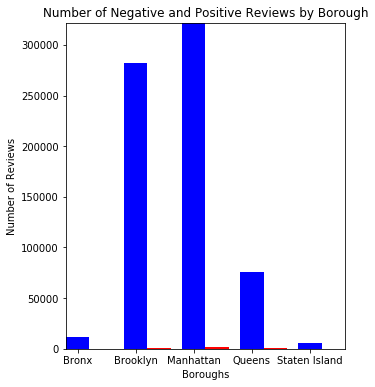

In [216]:
fig, ax = plt.subplots(figsize=(11,6))

x=range(len(y))
x1=[0.4,1.4,2.4,3.4,4.4]

y=reviewsmergels['goodcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()
z=reviewsmergels['badcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()

ax=plt.subplot(121)
ax.bar(x,y,color='b',width=0.4,align='center')
ax.bar(x1,z,color='r',width=0.4,align='center')
plt.xlabel('Boroughs')
plt.xticks((0,1,2,3,4),['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.ylabel('Number of Reviews')
plt.title('Number of Negative and Positive Reviews by Borough')
ax.autoscale(tight=True)
##Need to add legend if we want to use this graph

plt.show()

Since there is such a small amount of negative reviews compared to positive, this is a terrible graph to compare the two. However, it does get the point across that there appears to be hardly any negative reviews compared to positive ones. In the next graph we plot the two separately, so we can see the distributions of the negative reviews as well as the positive reviews for each borough. It is important to note that the range of the y-axis scales are very different.

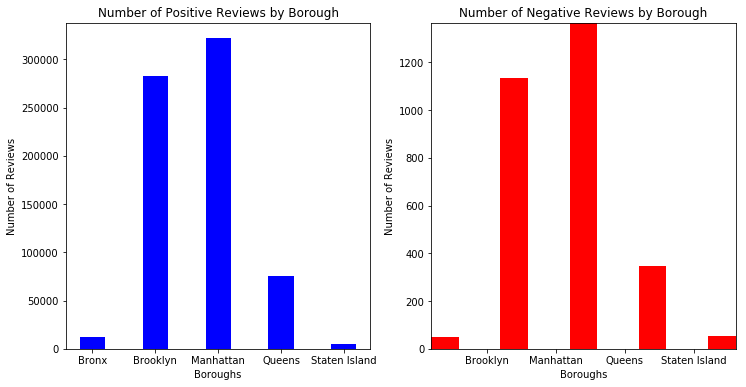

In [207]:
fig, ax = plt.subplots(figsize=(12,6))
x=range(len(y))
x1=[0.4,1.4,2.4,3.4,4.4]
y=reviewsmergels['goodcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()
z=reviewsmergels['badcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()
ax=plt.subplot(121)
ax.bar(x,y,color='b',width=0.4,align='center')
plt.xlabel('Boroughs')
plt.xticks((0,1,2,3,4),['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.ylabel('Number of Reviews')
plt.title('Number of Positive Reviews by Borough')

ax=plt.subplot(122)
ax.bar(x1,z,color='r',width=0.4,align='center')
plt.xlabel('Boroughs')
plt.xticks((0,1,2,3,4),['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.ylabel('Number of Reviews')
plt.title('Number of Negative Reviews by Borough')

ax.autoscale(tight=True)

plt.show()

In [ ]:
pd.reset_option("^display")

### Question 2: 
Do factors such as number of minimum nights, cancellation policy, instant bookable, and house rules affect the popularity of an Airbnb?

### Question 3: 
How important are reviews and how much do they affect whether or not an Airbnb gets booked?

### Question 4: 
Do amenities, access (entire apartment vs private room), room type (private vs shared), transit, or number of guests significantly impact whether or not an Airbnb is booked?

### Question 5:
What hosts are busiest? Why?

### Visualize Data on Map
- What areas are most popular? why?

#### Number of Airbnbs by Neighbourhood

In [89]:
#Use host id since there are no missing - meaning we get every record when counting
ls['host_id'].groupby(ls['neighbourhood_group']).count()

neighbourhood_group
Bronx              791
Brooklyn         18470
Manhattan        20370
Queens            4392
Staten Island      294
Name: host_id, dtype: int64

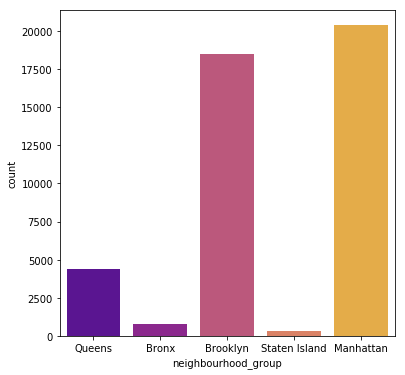

In [88]:
#https://www.kaggle.com/darkrubiks/nyc-airbnb-exploratory-analysis
#Amount of Airbnbs by borough
plt.figure(figsize=(6,6))
ax = sns.countplot(ls["neighbourhood_group"], palette="plasma" ) 
plt.title('Number of Airbnb\'s by Borough',color = 'k',fontsize = 15)

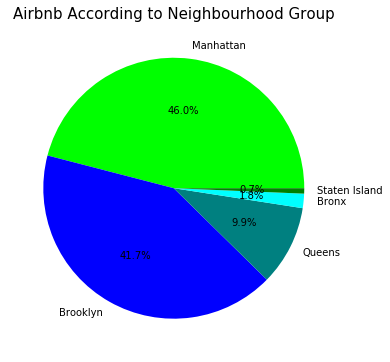

In [122]:
labels = ls.neighbourhood_group.value_counts().index
colors = ['lime','blue','teal','cyan','green']
explode = [0,0,0,0,0]
sizes = ls.neighbourhood_group.value_counts().values

plt.figure(0,figsize = (6,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Airbnb According to Neighbourhood Group',color = 'k',fontsize = 15)
plt.show()

Things to explore and fix later

In [86]:
ld=listing_details[['guests_included','extra_people','minimum_nights','listing_url','house_rules','cancellation_policy','instant_bookable','amenities','price','weekly_price','monthly_price','room_type','neighbourhood','reviews_per_month','longitude','latitude']]

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

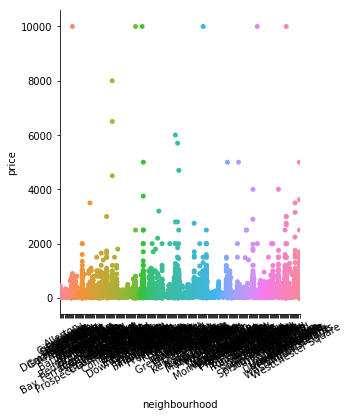

In [42]:
g=sns.catplot(x = "neighbourhood", y = "price", data=ls)
g.set_xticklabels(rotation=30)
#sns.set(rc={'figure.figsize':(40,20)})
